<a href="https://colab.research.google.com/github/silvershine157/ML_Practice/blob/master/SteinVGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stein Variational Gradient Descent


In [0]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch.distributions as dist
import torch.nn as nn

## SGVD Algorithm

### What does it do?

Let $p$ be a smooth distribution on $\mathcal{X}$.

if we can evaluate $\nabla_x log\,p(x) |_{x=x'}$ for any given $x' \in \mathcal{X}$,

then SVGD algorithm can generate approximate samples from $p$ by iteratively guiding the particles.

In [0]:
def svgd_run(grad_log_p, dim):
  n_iter = 100
  n_samples = 100
  X = torch.rand(n_samples, dim)
  for _ in range(n_iter):
    X = svgd_update(X, grad_log_p)
  return X # samples from p

### Why is it useful?

Suppose we want to evaluate $\int_{\mathcal{X}}{g(x) p(x)dx}$ where we have unnormalized $\bar{p}(x)$ rather than $p(x) = \frac{\bar{p}(x)}{\int_{\mathcal{X}}{\bar{p}(x)dx}}$.

Analytic integration is often impossible for complex $g$, $p$ and normalization can be intractable.

Instead, if we have samples $x_i$ from $p$, then we can construct a MC estimator:
$\int_{\mathcal{X}}{g(x) p(x)dx} = \mathbb{E}_{\mathbb{x} \sim p}[g(\mathbb{x})] \approx \frac{1}{N} \sum_{i=1}^N{g(x_i)}$



In [0]:
def estimate_integral(g, samples_from_p):  
  # Estimate integral
  g_values = []
  for x in samples_from_p:
    g_values.append(g(x)) # g forward
  est = sum(g_values)/len(g_values)
  return est

Drawing samples using MCMC methods are rather slow or unreliable.

Meanwhile, SGVD only uses $\nabla_x log\,p(x)$, which is exactly same as $\nabla_x log\,\bar{p}(x)$.

Therefore, only forward pass of $g$ and forward/backward pass of $\bar{p}$ is necessary and nothing else!

In [0]:
# Transform forward function into gradient function
def fwd_to_grad(f):
  def grad_func(x):
    x = x.requires_grad_(True)
    r = f(x)
    r.backward()
    grad = x.grad
    x = x.requires_grad_(False)
    return grad
  return grad_func

# Sample from unnormalized log likelihood
def sample_unnormalized(log_p_bar, dim):
  # Gradient of log-likelihood
  grad_log_p = fwd_to_grad(log_p_bar) # normalization doesn't matter
  # Use SVGD to draw samples from p
  samples_from_p = svgd_run(grad_log_p, dim)
  return samples_from_p

### How does it work?


**Update rule**

$x_i^{l+1} = x_i^l + \epsilon_l \hat{\phi}^*(x_i^l)$

$\hat{\phi}^*(x_i^l) = \frac{1}{n}\sum_{j=1}^n[k(x_j^l, x_i^l) \nabla_{x_j^l} log\,p(x_j^l) + \nabla_{x_j^l} k(x_j^l, x_i^l)]$

In [0]:
def rbf_kernel(X):
  n_samples = X.size(0)
  X = X.unsqueeze(dim=1) # (i, 1, d)
  X_T = X.transpose(0, 1) # (1, j, d)
  D = X - X_T # (i, j, d)
  SqD = torch.sum(D**2, dim=2) # (i, j)
  medSqD = torch.median(SqD)
  if n_samples <= 3:
    h = 1.0
  else:
    h = medSqD / (math.log(n_samples))
  K = torch.exp((-1/h)*SqD) # (i, j)
  grad_K = (2/h)*torch.einsum('ijd,ij->ijd', D, K) # (i, j ,d)
  return K, grad_K

def svgd_update(X, grad_log_p, kernel=rbf_kernel):
  # TODO: adagrad step_size
  n_samples = X.size(0)
  P = torch.zeros(X.size())
  for j in range(n_samples): # TODO: must be a better way (think neural network)
    P[j, :] = grad_log_p(X[j, :]) # (j, d)
  K, grad_K = kernel(X) # (i, j), (i, j, d)
  S = torch.einsum('ij,jd->ijd', K, P) + grad_K # (i, j, d)
  phi = torch.sum(S, dim=1)/n_samples # (i, d)
  return phi

def adagrad(phi, sq_acc, lr=1.0):
  sq_acc = sq_acc + torch.pow(phi, 2)
  step_sizes = lr * torch.pow(sq_acc+0.001, -0.5)
  return step_sizes, sq_acc

## Experiment 1: Mixture of Gaussian

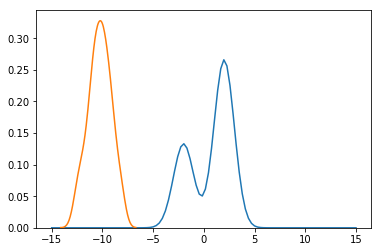

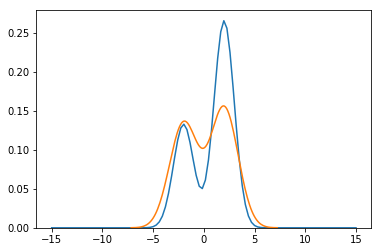

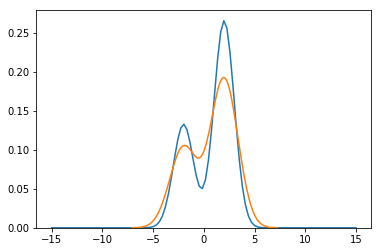

In [353]:
# Mixture of Gaussian as target
g1 = dist.normal.Normal(-2, 1)
g2 = dist.normal.Normal(2, 1)
target_p = lambda x: (1/3)*torch.exp(g1.log_prob(x)) + (2/3)*torch.exp(g2.log_prob(x))
grad_log_p = fwd_to_grad(lambda x: torch.log(target_p(x)))

grid = torch.linspace(-15, 15)
Y = target_p(grid)
grid = grid.numpy()
Y = Y.numpy()

# initialize
n_samples = 100
dim=1
g0 = dist.normal.Normal(-10, 1)
X = g0.sample((n_samples, dim))

sq_acc=0.0

# update
for _ in range(2):
  sns.lineplot(grid, Y)
  fig = sns.distplot(X.squeeze(dim=1).numpy(), hist=False)
  plt.show()
  for _ in range(50):
    phi = svgd_update(X, grad_log_p)
    step_sizes, sq_acc = adagrad(phi, sq_acc, lr=5.0)
    X = X + torch.mul(step_sizes, phi)
sns.lineplot(grid, Y)
fig = sns.distplot(X.squeeze(dim=1).numpy(), hist=False)
plt.show()

This is very numerically unstable.
Big step size -> far from mode -> almost zero prob -> log gives NaN

Why AdaGrad? <- does not guarantee minimization of KL div?

learning rate matters

## Experiment 2: Bayesian Neural Network

**log PDF of Gaussian**

$log(\mathcal{N}(t | \mu, \gamma^{-1}))
\\=log(\frac{1}{\sqrt{2 \pi \gamma^-2}}exp(-\frac{(t - \mu)^2}{2 \gamma^{-2}}))
\\=log(\frac{\gamma}{\sqrt{2 \pi}}exp(-\frac{(\gamma(t - \mu))^2}{2}))
\\=log\,\gamma -\frac{(\gamma(t - \mu))^2}{2} - \frac{1}{2}log(2\pi)$

**Likelihood**

$p(Y|W, X, \gamma) = \prod_{i=1}^N {\mathcal{N}(y_i | f(x_i; W), \gamma^{-1})}$

**Prior**

$p(W| \lambda)= \prod_{k=1}^K {\mathcal{N}(w_k|0, \lambda^{-1})}$

**Hyperpriors**

$p(\gamma) = Gamma(\gamma | \alpha_0, \beta_0)
\\p(\lambda) = Gamma(\lambda | \alpha_0, \beta_0)$

**Posterior**

$p(W, \gamma, \lambda | X, Y) \propto p(Y | W, X, \gamma) p(W | \lambda) p(\gamma) p(\lambda)$

In [0]:
def log_gaussian_pdf(t, mu, log_inv_scale):
  # exact
  half_log_2pi = 0.5 * math.log(2 * math.pi)
  indiv = log_inv_scale - 0.5*torch.pow(torch.exp(log_inv_scale)*(t - mu), 2) - half_log_2pi
  return torch.sum(indiv)

def log_likelihood(Y, W, X, log_gamma, mlp):
  # exact
  return log_gaussian_pdf(Y, mlp(X, W), log_gamma)

def log_prior(W, log_lambda):
  # exact
  #param_vec = nn.utils.parameters_to_vector(net.parameters())
  return log_gaussian_pdf(W, 0.0, log_lambda)

def log_hyperprior(z, alpha=1.0, beta=0.1):
  # log pdf of Z where Z = log(G), G ~ Gamma(alpha, beta)
  # correct up to constant addition
  return beta*z - (1/alpha)*torch.exp(z)

def log_posterior(W, log_gamma, log_lambda, X, Y, mlp):
  # correct up to constant addition
  llike = log_likelihood(Y, W, X, log_gamma, mlp)
  lpri = log_prior(W, log_lambda)
  lhypri_gamma = log_hyperprior(log_gamma)
  lhypri_lambda = log_hyperprior(log_lambda)
  return llike + lpri + lhypri_gamma + lhypri_lambda

### BNN training routine

181
176
186
torch.Size([181])
torch.Size([5])

In [0]:
def make_mlp(X_dim, hidden_units=10):
  W_dim = (X_dim+1)*hidden_units + (hidden_units+1)*1
  relu = nn.ReLU()
  def mlp(X, W):
    X = X.transpose(1, 0) # (X_dim, B)
    t = hidden_units * X_dim
    w1 = W[0:t].view(hidden_units, X_dim)
    b1 = W[t:t+hidden_units].view(hidden_units, 1)
    w2 = W[t+hidden_units:t+2*hidden_units].view(1, hidden_units)
    b2 = W[-1]
    z1 = torch.mm(w1, X) + b1
    a1 = relu(z1)
    z2 = torch.mm(w2, a1) + b2
    return z2.transpose(1, 0) # (B)
  return mlp, W_dim

def unpack_v(v):
  W, log_gamma, log_lambda = v[:-2], v[-2], v[-1]
  return W, log_gamma, log_lambda
  
def make_grad_BNN(X, Y, mlp):
  def fwd_BNN_posterior(v):
    W, log_gamma, log_lambda = unpack_v(v)
    return log_posterior(W, log_gamma, log_lambda, X, Y, mlp)
  grad_BNN_posterior = fwd_to_grad(fwd_BNN_posterior)
  return grad_BNN_posterior

def train_BNN(X, Y, mlp, W_dim, n_samples, n_iters):
  # dimensions
  batch_size = X.size(0)
  X_dim = X.size(1)
  v_dim = W_dim + 2 # MLP weights, log gamma, log lambda

  # initialize
  grad_log_post_v = make_grad(X, Y, mlp)
  init_dist = dist.normal.Normal(0, 0.1)
  V = init_dist.sample((n_samples, v_dim))
  
  # SVGD
  sq_acc=0.0
  for _ in range(n_iters):
    grad_BNN_posterior = make_grad_BNN(X, Y, mlp)
    phi = svgd_update(V, grad_BNN_posterior)
    step_sizes, sq_acc = adagrad(phi, sq_acc)
    V = V + torch.mul(step_sizes, phi)
  return V

### Train using toy data

In [0]:
def make_toy_data(N):
  # ground truth model
  X_dim = 3
  GT_X_dist = dist.normal.Normal(0., 3.)
  GT_mlp, GT_W_dim = make_mlp(X_dim, hidden_units=2)
  GT_W_dist = dist.normal.Normal(0., 1.)
  GT_W = GT_W_dist.sample([GT_W_dim])
  GT_inv_gamma = 0.1
  GT_noise_dist = dist.normal.Normal(0., GT_inv_gamma)
  GT_log_gamma = -torch.log(torch.Tensor([GT_inv_gamma]))
  # generate data
  X = GT_X_dist.sample([N, X_dim])
  noise = GT_noise_dist.sample([N, 1])
  Y = GT_mlp(X, GT_W) + noise
  return X, Y

def split_data(X, Y, test_ratio=0.2):
  N = X.size(0)
  N_test = int(test_ratio*N)
  N_train = N - N_test
  X_train, Y_train = X[:N_train, :], Y[:N_train, :]
  X_test, Y_test = X[N_train:, :], Y[N_train:, :]
  return X_train, Y_train, X_test, Y_test

X, Y = make_toy_data(300)
X_dim = X.size(1)

# setup
X_train, Y_train, X_test, Y_test = split_data(X, Y)

# build & train BNN
mlp, W_dim = make_mlp(X_dim, hidden_units=2)
good_V = train_BNN(X_train, Y_train, mlp, W_dim, n_samples=20, n_iters=1000)
bad_V = train_BNN(X_train, Y_train, mlp, W_dim, n_samples=20, n_iters=1)

### Evaluation

**inference**

$
p(\bar{y} | \bar{x}, X, Y) 
\\=\int{p(\bar{y} | Y|W, \bar{x}, \gamma)p(W, \gamma, \lambda | X, Y)dW d\gamma d\lambda}
\\=\int{\mathcal{N}(\bar{y} | f(\bar{x}; W), \gamma^{-1})p(W, \gamma, \lambda | X, Y)dW d\gamma d\lambda}
\\\approx \frac{1}{M}\sum_{m=1}^M{\mathcal{N}(\bar{y} | f(\bar{x}; W_m), \gamma_m^{-1})}
$

**bias-variance decomposition**

$\int{(y - \mu + b)^2\mathcal{N}(y | \mu, \sigma)dy}
\\=\int{((y - \mu)^2 + 2(y - \mu)b + b^2) \mathcal{N}(y | \mu, \sigma)dy}
\\=\sigma^2 + b^2$

**mean squared error for BNN**

$
\int{(y - \bar{y})^2\frac{1}{M}\sum_{m=1}^M{\mathcal{N}(y | f(\bar{x}; W_m), \gamma_m^{-1})} dy}
\\=\frac{1}{M}\sum_{m=1}^M{\int{(y - \bar{y})^2 \mathcal{N}(y | f(\bar{x}; W_m), \gamma_m^{-1}) dy}}
\\=\frac{1}{M}\sum_{m=1}^M[\gamma_m^{-2} + (f(\bar{x}; W_m) - \bar{y})^2]
$

In [469]:
def test_BNN(X_test, Y_test, V, mlp):
  N_data = X_test.size(0)
  n_samples = V.size(0)
  sq_err_sum = 0.0
  ll_sum = 0.0
  for m in range(n_samples):
    v = V[m, :]
    W, log_gamma, log_lambda = unpack_v(v)
    variance = torch.pow(torch.exp(-log_gamma), 2)
    bias = mlp(X_test, W) - Y_test
    sq_err = torch.mul(bias, bias) + variance
    sq_err_sum += torch.sum(sq_err)
    ll_sum += log_likelihood(Y_test, W, X_test, log_gamma, mlp)
  rmse = torch.sqrt(sq_err_sum/(n_samples * N_data)).item()
  ll = (ll_sum/(n_samples * N_data)).item()
  #TODO: mse -> rmse -> avg over test datapoints??
  return rmse, ll

# compare good model and bad model
rmse, ll = test_BNN(X_test, Y_test, good_V, mlp)
print("Good model\tRMSE: %.3f\tLL: %.3f"%(rmse, ll))
rmse, ll = test_BNN(X_test, Y_test, bad_V, mlp)
print("Bad model\tRMSE: %.3f\tLL: %.3f"%(rmse, ll))

Good model	RMSE: 1.762	LL: -1.848
Bad model	RMSE: 71.805	LL: -19033.371


### Naval Dataset

In [397]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI%20CBM%20Dataset.zip -O ./naval.zip
!unzip -o naval.zip

--2019-07-26 06:06:58--  http://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI%20CBM%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 567071 (554K) [application/x-httpd-php]
Saving to: ‘./naval.zip’

./naval.zip         100%[===================>] 553.78K  2.93MB/s    in 0.2s    

2019-07-26 06:06:59 (2.93 MB/s) - ‘./naval.zip’ saved [567071/567071]

Archive:  naval.zip
  inflating: UCI CBM Dataset/.DS_Store  
  inflating: __MACOSX/UCI CBM Dataset/._.DS_Store  
  inflating: UCI CBM Dataset/data.txt  
  inflating: UCI CBM Dataset/Features.txt  
  inflating: __MACOSX/UCI CBM Dataset/._Features.txt  
  inflating: UCI CBM Dataset/README.txt  
  inflating: __MACOSX/UCI CBM Dataset/._README.txt  


In [433]:
# read data from file
with open('UCI CBM Dataset/data.txt') as datafile:
  data = []
  for line in datafile:
    row = [float(tok) for tok in line.strip().split()]
    data.append(row)
  data = torch.Tensor(data)

# normalize data
mean = torch.mean(data, dim=0)
scale = torch.std(data, dim=0)
data = (data - mean)/(scale+0.001)

# split data
X = data[:, :16]
Y = data[:, 16].view(-1, 1)
X_train, Y_train, X_test, Y_test = split_data(X, Y)
print(X_train.size())
print(X_test.size())

torch.Size([9548, 16])
torch.Size([2386, 16])


In [476]:
mlp, W_dim = make_mlp(X_dim=X_train.size(1), hidden_units=10)
good_V = train_BNN(X_train, Y_train, mlp, W_dim, n_samples=1, n_iters=100)
bad_V = train_BNN(X_train, Y_train, mlp, W_dim, n_samples=1, n_iters=1)

# compare good model and bad model
rmse, ll = test_BNN(X_test, Y_test, good_V, mlp)
print("Good model\tRMSE: %.3f\tLL: %.3f"%(rmse, ll))
rmse, ll = test_BNN(X_test, Y_test, bad_V, mlp)
print("Bad model\tRMSE: %.3f\tLL: %.3f"%(rmse, ll))


Good model	RMSE: 1.690	LL: -2.094
Bad model	RMSE: 69.682	LL: -519.103
